<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/Data%20Cleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

https://www.kaggle.com/datasets/thedevastator/berlin-airbnb-ratings-how-hosts-measure-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# missing data
!pip install missingno -q
import missingno as msno

# for grid
!pip install geopy -q
from geopy.distance import geodesic

!pip install pandas numpy libpysal geopy esda -q
from geopy.distance import great_circle

# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.8 MB/s eta 0:00:00


In [39]:
apartments_3 = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_3.xlsx', engine='openpyxl')

In [51]:
apartments = apartments_3.copy()

In [52]:
import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/lat_bin.pkl -q
!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/lon_bin.pkl -q

with open('lat_bin.pkl', 'rb') as f:
    lat_bin = pickle.load(f)

with open('lon_bin.pkl', 'rb') as f:
    lon_bin = pickle.load(f)


# Data Cleansing

# Filling missing data


## Post Code

Find the nearest object with filled Post Code.

We use grid to do it quicklly

In [53]:
def fill_missing_postal_codes(apartments):
    """
    """
    apartments_filled = apartments.copy()
    missing_indices = apartments_filled['Postal Code'].isnull()

    for i in apartments_filled[missing_indices].index:
        lat = apartments_filled.loc[i, 'Latitude']
        lon = apartments_filled.loc[i, 'Longitude']
        lat_bin = apartments_filled.loc[i, 'Latitude_Bin']
        lon_bin = apartments_filled.loc[i, 'Longitude_Bin']

        search_radius = 1  # begin +/-1 bin
        found = False
        while not found:
            nearby_apartments = apartments_filled[
                (apartments_filled['Latitude_Bin'].between(lat_bin - search_radius, lat_bin + search_radius)) &
                (apartments_filled['Longitude_Bin'].between(lon_bin - search_radius, lon_bin + search_radius)) &
                (~apartments_filled['Postal Code'].isnull())
            ]

            if not nearby_apartments.empty:
                distances = nearby_apartments.apply(
                    lambda row: great_circle((lat, lon), (row['Latitude'], row['Longitude'])).km,
                    axis=1
                )
                nearest_index = distances.idxmin()
                apartments_filled.loc[i, 'Postal Code'] = apartments_filled.loc[nearest_index, 'Postal Code']
                found = True
            else:
                search_radius += 1

    return apartments_filled

apartments = fill_missing_postal_codes(apartments)
apartments['Postal Code'].isnull().sum()

0

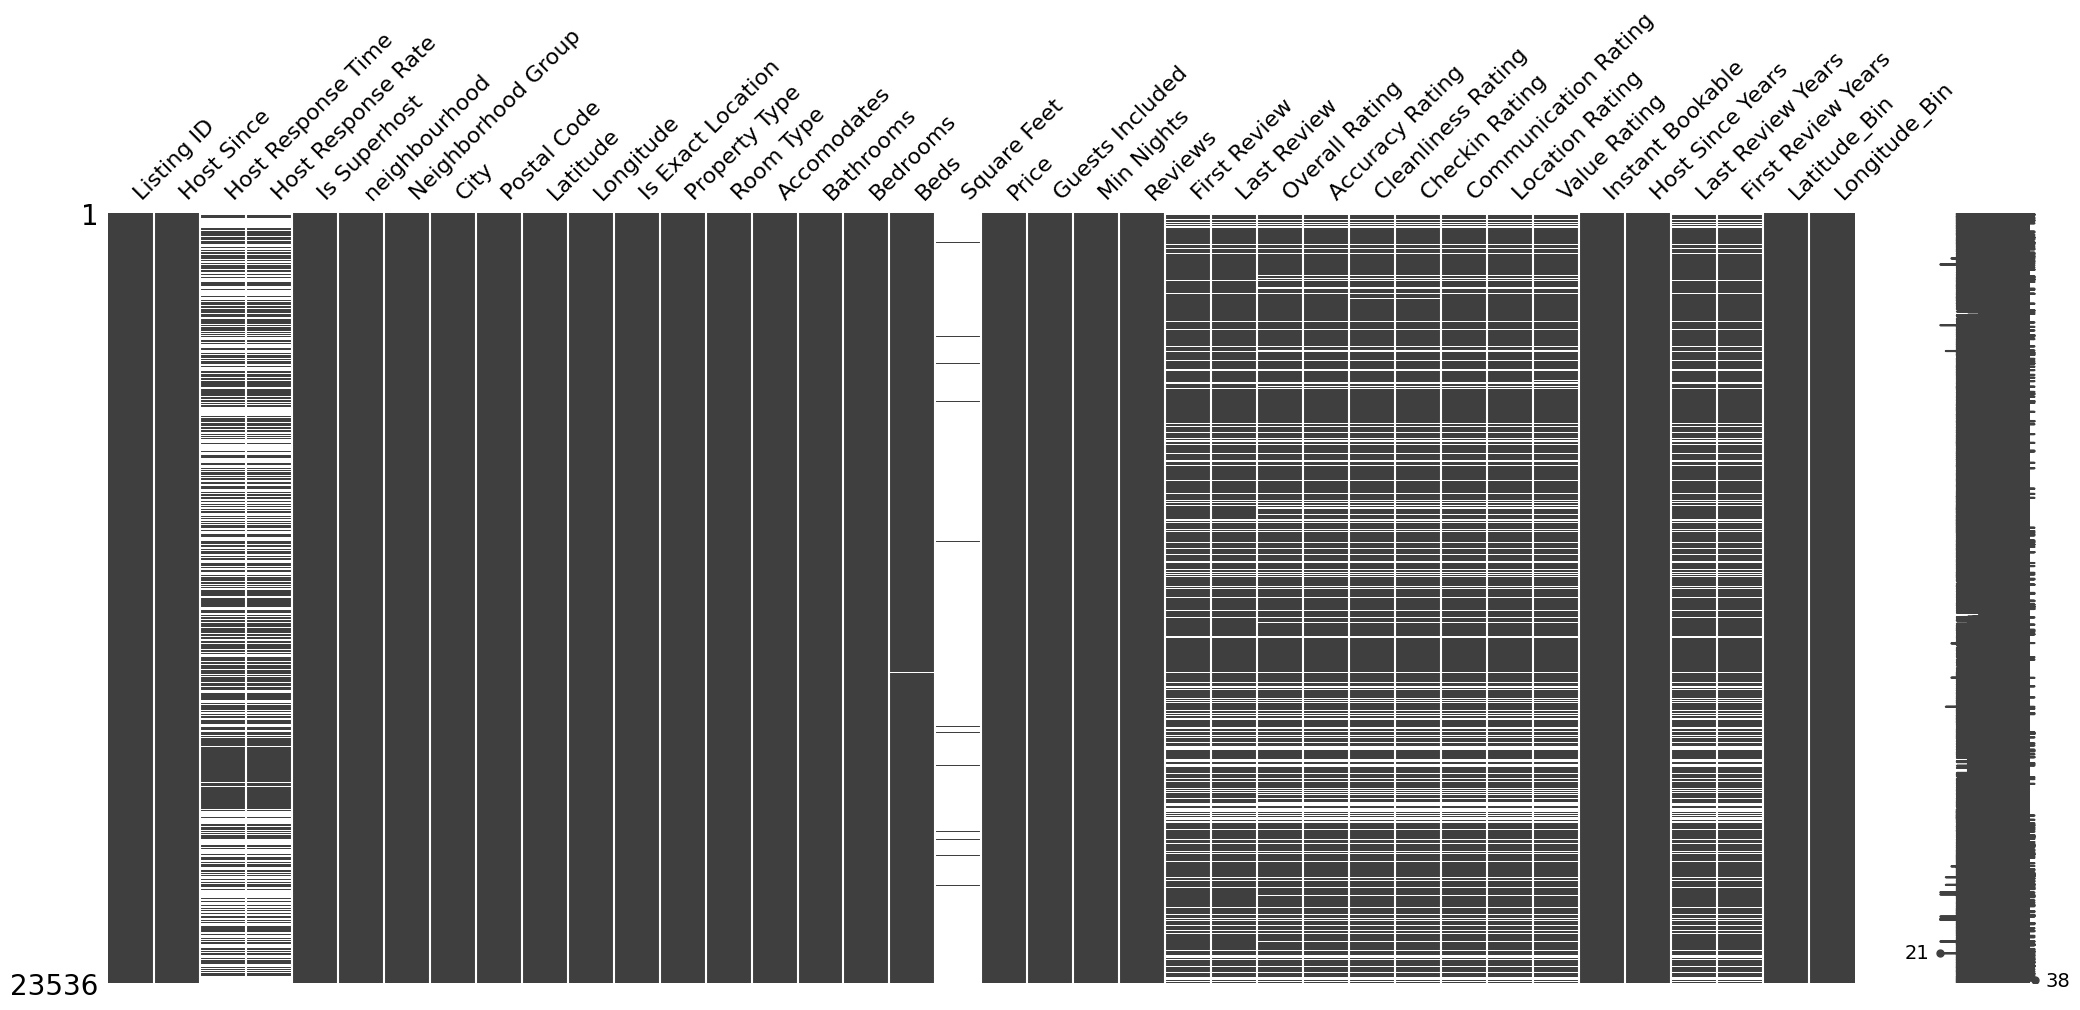

In [54]:
msno.matrix(apartments)
plt.show()

<Axes: >

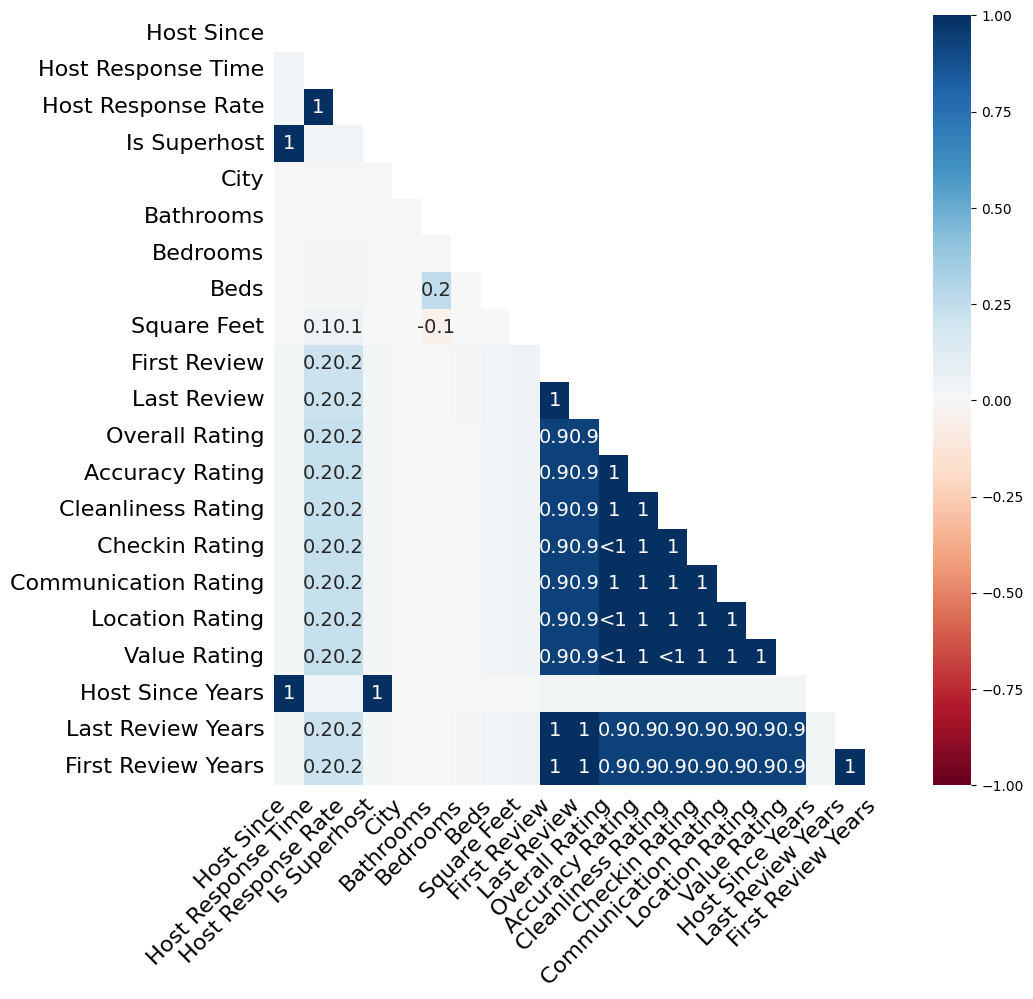

In [55]:
msno.heatmap(apartments,figsize=(10,10))

In [56]:
# Calculate the proportion of missing values for columns with missing data
missing_proportions = apartments.isnull().sum() / len(apartments)
print(missing_proportions[missing_proportions > 0])

Host Since              0.000892
Host Response Time      0.445700
Host Response Rate      0.445700
Is Superhost            0.000892
City                    0.000127
Bathrooms               0.001232
Bedrooms                0.000850
Beds                    0.001487
Square Feet             0.981943
First Review            0.176581
Last Review             0.176581
Overall Rating          0.196380
Accuracy Rating         0.197485
Cleanliness Rating      0.197315
Checkin Rating          0.198249
Communication Rating    0.197570
Location Rating         0.198207
Value Rating            0.198334
Host Since Years        0.000892
Last Review Years       0.176581
First Review Years      0.176581
dtype: float64


## Filling using MICE

In [57]:
!pip install fancyimpute -q
from fancyimpute import IterativeImputer

# Select only numeric columns for imputation
numeric_columns = apartments.select_dtypes(include=np.number).columns
apartments_numeric = apartments[numeric_columns]

# Perform MICE imputation
mice_imputer = IterativeImputer()
apartments_imputed = mice_imputer.fit_transform(apartments_numeric)

# Convert the imputed array back to a DataFrame
apartments_imputed = pd.DataFrame(apartments_imputed, columns=numeric_columns)

apartments['Host Since Years'] = apartments_imputed['Host Since Years']

# Округление результатов до целых чисел
apartments_imputed[['Bathrooms', 'Bedrooms', 'Beds']] = apartments_imputed[['Bathrooms', 'Bedrooms', 'Beds']].round(0).astype(int)
# Update the original DataFrame with imputed values for 'Bathrooms' and 'Beds'
apartments['Bathrooms'] = apartments_imputed['Bathrooms']
apartments['Bedrooms'] = apartments_imputed['Bedrooms']
apartments['Beds'] = apartments_imputed['Beds']


In [58]:
# Calculate the proportion of missing values for columns with missing data
missing_proportions = apartments.isnull().sum() / len(apartments)
print(missing_proportions[missing_proportions > 0])

Host Since              0.000892
Host Response Time      0.445700
Host Response Rate      0.445700
Is Superhost            0.000892
City                    0.000127
Square Feet             0.981943
First Review            0.176581
Last Review             0.176581
Overall Rating          0.196380
Accuracy Rating         0.197485
Cleanliness Rating      0.197315
Checkin Rating          0.198249
Communication Rating    0.197570
Location Rating         0.198207
Value Rating            0.198334
Last Review Years       0.176581
First Review Years      0.176581
dtype: float64


## Selecting feachers for analysis

### Drop noninformtive columns and specific types

In [59]:
# drop noninformtive columns
apartments = apartments.drop(['City', 'Square Feet'], axis=1)
apartments.shape

(23536, 36)

In [60]:
apartments = apartments[apartments['Property Type'].isin(['Apartment', 'Condominium'])]
apartments = apartments[apartments['Room Type'] != 'Shared room']
apartments.shape

(21306, 36)

# Outliers

### Boxplot of Outliers

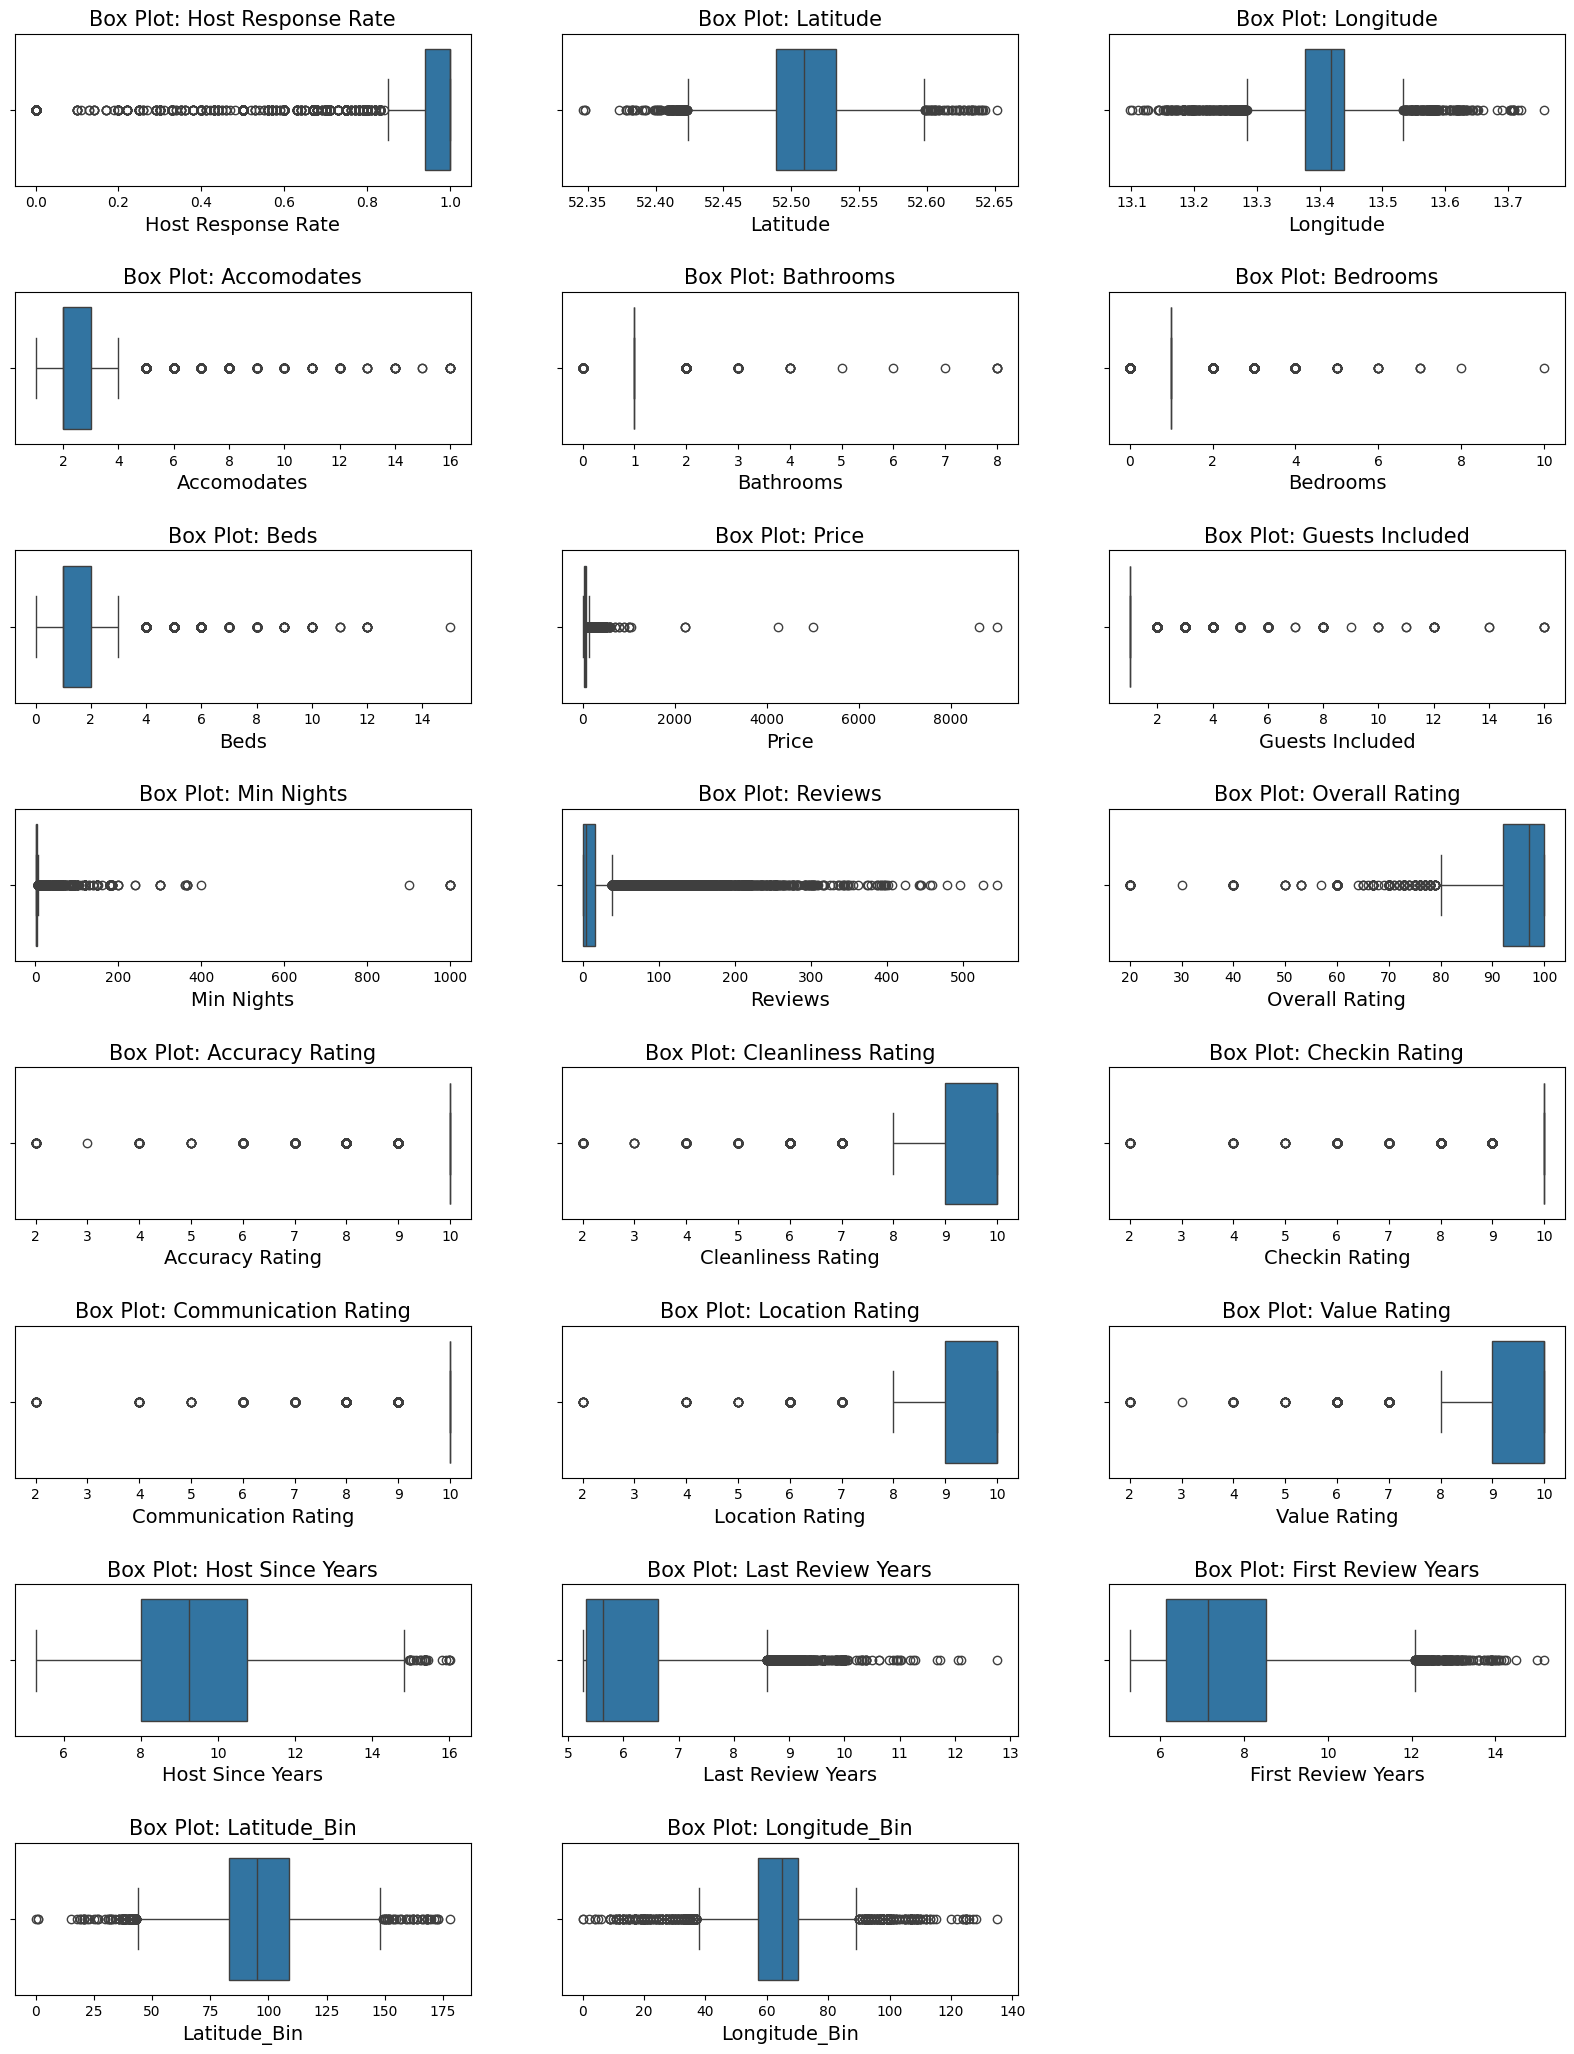

In [62]:
apartments['Listing ID'] = apartments['Listing ID'].astype(str)
apartments['Postal Code'] = apartments['Postal Code'].astype(str)

numeric_cols = apartments.select_dtypes(include='number').columns

plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(apartments[numeric_cols])

### Min Nights Outliers

In [73]:
# apartments['Min Nights']
min_nights_counts = apartments['Min Nights'].value_counts().sort_index()
min_nights_counts_cumsum = min_nights_counts.cumsum()
min_nights_counts_percentage = min_nights_counts_cumsum / min_nights_counts_cumsum.iloc[-1] * 100

result_df = pd.DataFrame({
    'Min Nights': min_nights_counts.index,
    'Count': min_nights_counts.values,
    'Cumulative Percentage': min_nights_counts_percentage.values
})
result_df

,Min Nights,Count,Cumulative Percentage
0,1,4675,22.140658
1,2,5502,48.197964
2,3,4243,68.292683
3,4,1658,76.144921
4,5,1414,82.841582
5,6,473,85.081695
6,7,860,89.154629
7,8,67,89.471939
8,9,50,89.708738
9,10,297,91.115321


In [74]:
apartments = apartments[apartments['Min Nights'] <= 14]
apartments.shape

(19664, 37)

### Price Outliers

Data transformation for analisis

In [75]:
apartments['Price Log'] = np.log1p(apartments['Price'])

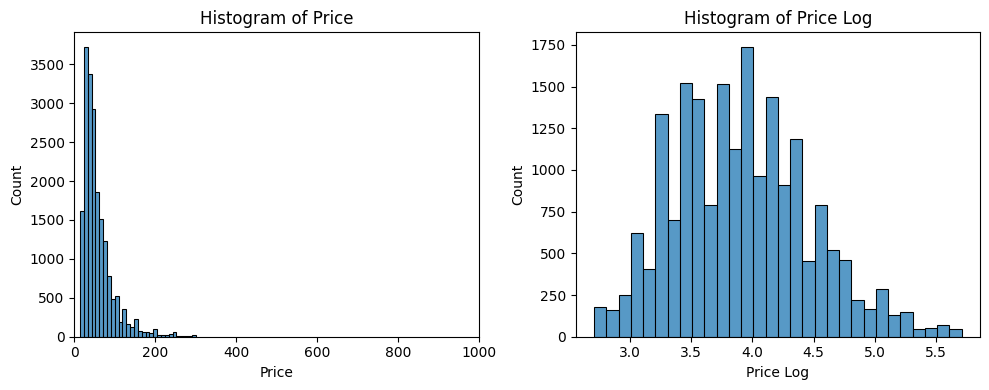

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the first and second histogram
sns.histplot(apartments['Price'], bins=30, ax=axes[0])
axes[0].set_xlim(0, 1000)
axes[0].set_title('Histogram of Price')
sns.histplot(apartments['Price Log'], bins=30, ax=axes[1])
axes[1].set_title('Histogram of Price Log')

plt.tight_layout()

plt.show()

In [78]:
# Calculate mean and standard deviation of 'Price'
mean_price = apartments['Price'].mean()
std_price = apartments['Price'].std()
# Calculate +/- 3 sigma
three_sigma_lower = mean_price - 3 * std_price
three_sigma_upper = mean_price + 3 * std_price

# # Calculate 1.5 IQR
q1 = apartments['Price'].quantile(0.25)
q3 = apartments['Price'].quantile(0.75)
iqr = q3 - q1
iqr_lower = q1 - 1.5 * iqr
iqr_upper = q3 + 1.5 * iqr

print("Mean Price:", mean_price)
print("Standard Deviation Price:", std_price,'\n')
print("Сalculated boundaries based on initial data")
print("3 Sigma Lower:", three_sigma_lower)
print("3 Sigma Upper:", three_sigma_upper)
print("1.5 IQR Lower:", iqr_lower)
print("1.5 IQR Upper:", iqr_upper,'\n')


# Calculate mean and standard deviation of 'Price Log'
mean_price_log = apartments['Price Log'].mean()
std_price_log = apartments['Price Log'].std()

# Calculate +/- 3 sigma
three_sigma_lower_log = mean_price_log - 3 * std_price_log
three_sigma_upper_log = mean_price_log + 3 * std_price_log

# Calculate 1.5 IQR
q1_log = apartments['Price Log'].quantile(0.25)
q3_log = apartments['Price Log'].quantile(0.75)
iqr_log = q3_log - q1_log
iqr_lower_log = q1_log - 1.5 * iqr_log
iqr_upper_log = q3_log + 1.5 * iqr_log

# Inverse transform to get Price values
three_sigma_lower_price = np.expm1(three_sigma_lower_log)
three_sigma_upper_price = np.expm1(three_sigma_upper_log)
iqr_lower_price = np.expm1(iqr_lower_log)
iqr_upper_price = np.expm1(iqr_upper_log)

# Print results in original Price scale
print("Сalculated boundaries based on transformed data")
print("3 Sigma Lower (Price):", three_sigma_lower_price)
print("3 Sigma Upper (Price):", three_sigma_upper_price)
print("1.5 IQR Lower (Price):", iqr_lower_price)
print("1.5 IQR Upper (Price):", iqr_upper_price)


Mean Price: 57.50422091131001
Standard Deviation Price: 38.647678690732334 

Сalculated boundaries based on initial data
3 Sigma Lower: -58.438815160886996
3 Sigma Upper: 173.447256983507
1.5 IQR Lower: -27.5
1.5 IQR Upper: 128.5 

Сalculated boundaries based on transformed data
3 Sigma Lower (Price): 8.444098730653781
3 Sigma Upper (Price): 259.88134873222157
1.5 IQR Lower (Price): 8.682498150938697
1.5 IQR Upper (Price): 233.65018681978614


In [79]:
Q98 = apartments['Price'].quantile(0.98)
Q99 = apartments['Price'].quantile(0.99)
Q995 = apartments['Price'].quantile(0.995)

Q005 = apartments['Price'].quantile(0.005)
Q01 = apartments['Price'].quantile(0.01)
Q02 = apartments['Price'].quantile(0.02)

print("Q005", Q005)
print("Q01", Q01)
print("Q02", Q02, '\n')

print("Q98", Q98)
print("Q99", Q99)
print("Q995", Q995)

Q005 15.0
Q01 16.0
Q02 18.0 

Q98 180.0
Q99 210.0
Q995 250.0


In [80]:
apartments = apartments[(apartments['Price'] >= 14) & (apartments['Price'] <= 300)]
apartments.shape

(19664, 37)

### Outliers by apartments conditions

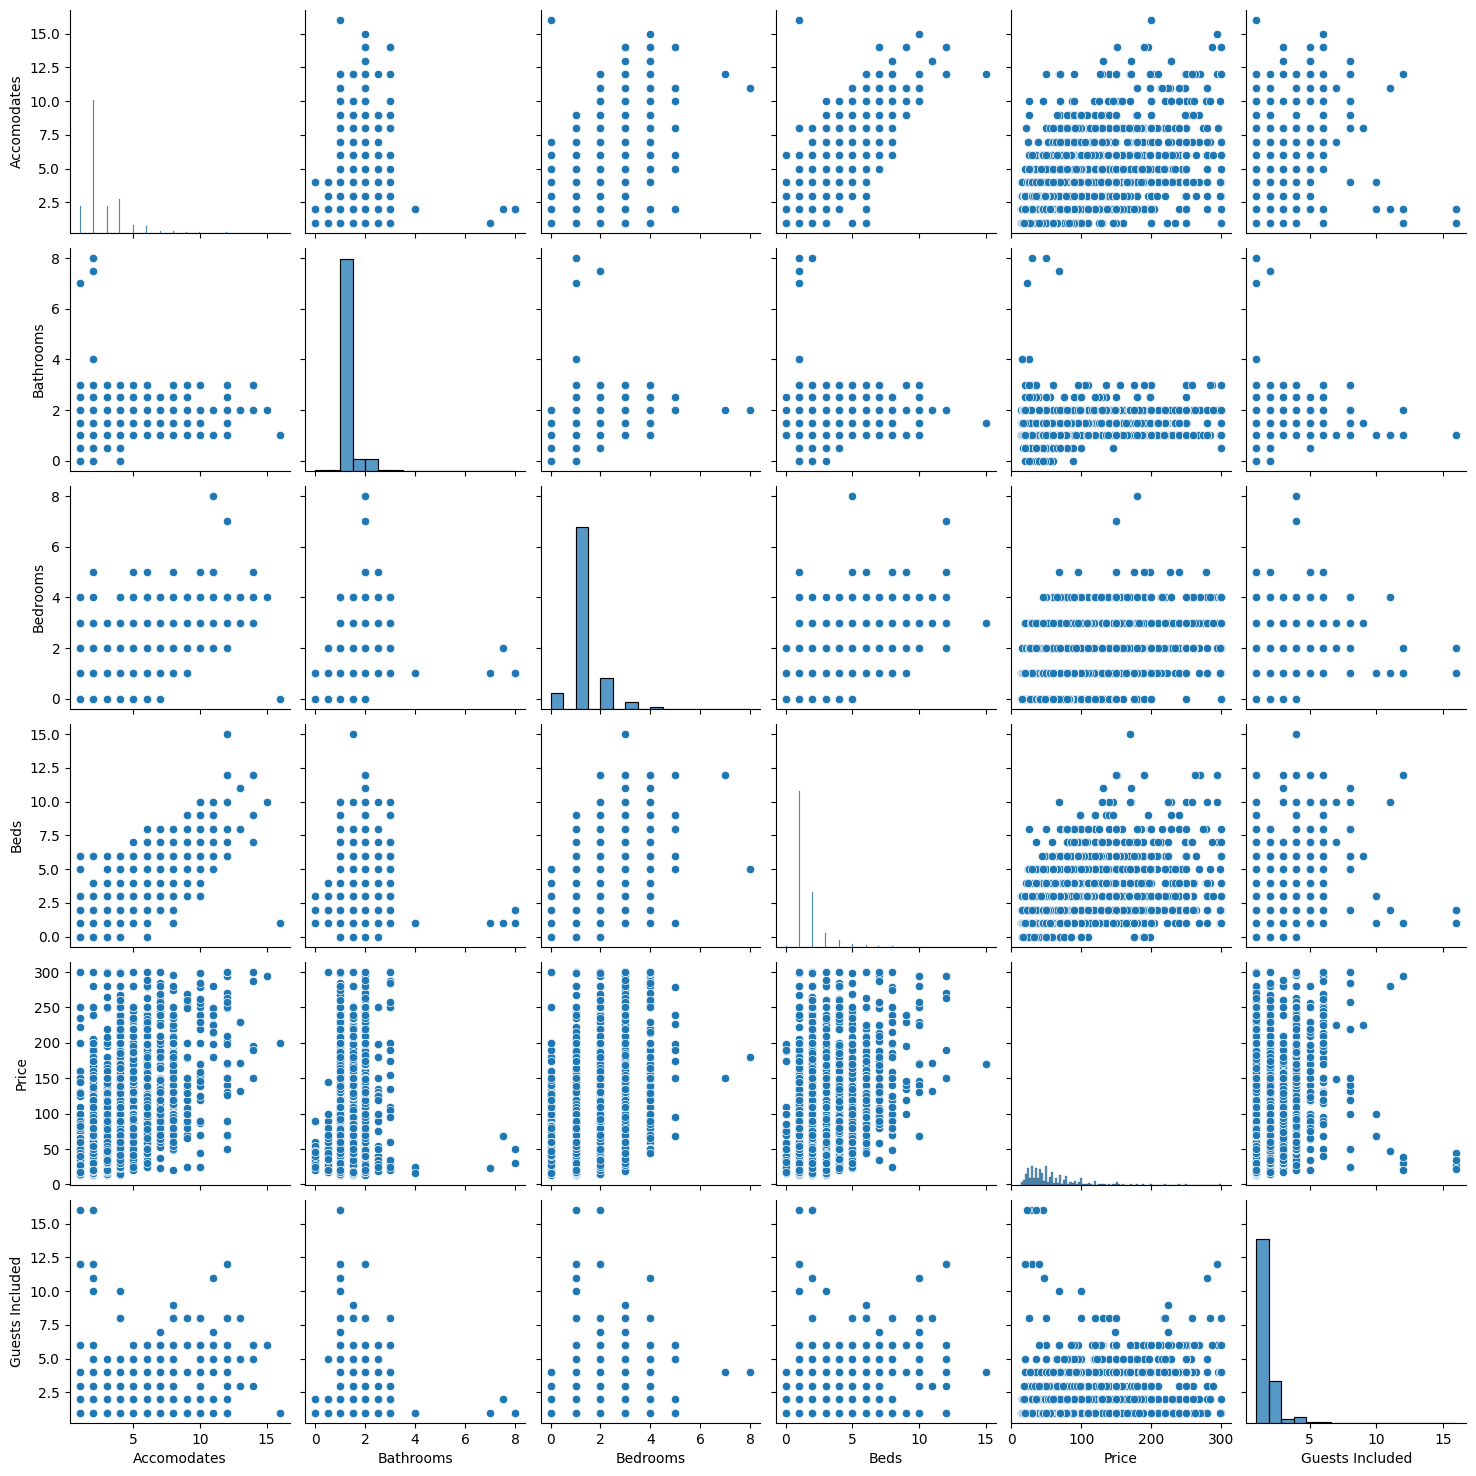

In [ ]:
columns_to_analyze = ['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Guests Included']

sns.pairplot(apartments[columns_to_analyze])

In [97]:
results = []

# Пройдите по каждому столбцу и рассчитайте статистику
for col in columns_to_analyze:
    mean = apartments[col].mean()
    std = apartments[col].std()
    min_val = apartments[col].min()
    max_val = apartments[col].max()

    # Границы по 3 сигма
    three_sigma_lower = mean - 3 * std
    three_sigma_upper = mean + 3 * std

    # Границы по 1.5 IQR
    q1 = apartments[col].quantile(0.25)
    q3 = apartments[col].quantile(0.75)
    iqr = q3 - q1
    iqr_lower = q1 - 1.5 * iqr
    iqr_upper = q3 + 1.5 * iqr

    # Добавьте результаты в список
    results.append({
        'Column': col,
        'Mean': mean,
        'Std': std,
        'Min': min_val,
        'Max': max_val,
        '3 Sigma Lower': three_sigma_lower,
        '3 Sigma Upper': three_sigma_upper,
        '1.5 IQR Lower': iqr_lower,
        '1.5 IQR Upper': iqr_upper
    })

# Создайте DataFrame из списка результатов
result_df = pd.DataFrame(results)

# Выведите результаты
result_df

,Column,Mean,Std,Min,Max,3 Sigma Lower,3 Sigma Upper,1.5 IQR Lower,1.5 IQR Upper
0,Accomodates,2.599929,1.400439,1,16,-1.601387,6.801245,0.5,4.5
1,Bathrooms,1.098098,0.330036,0,8,0.107990,2.088206,1.0,1.0
2,Bedrooms,1.141934,0.598905,0,8,-0.654780,2.938649,1.0,1.0
3,Beds,1.554414,1.050274,0,15,-1.596408,4.705236,-0.5,3.5
4,Guests Included,1.323027,0.780885,1,16,-1.019628,3.665682,1.0,1.0


In [98]:
def replace_outliers_with_nan(df, boundaries):
  """
  Заменяет значения вне заданных границ на NaN.

  Args:
    df: DataFrame для обработки.
    boundaries: Словарь с границами для каждого столбца.

  Returns:
    DataFrame с замененными значениями.
  """

  df_copy = df.copy()  # Создаем копию DataFrame, чтобы не изменять исходный

  for column, bounds in boundaries.items():
    lower_bound, upper_bound = bounds
    df_copy[column] = np.where((df_copy[column] < lower_bound) | (df_copy[column] > upper_bound),
                               np.nan, df_copy[column])

  return df_copy

# Пример использования:
boundaries = {
    'Accomodates': (1, 7),
    'Bathrooms': (1, 2),
    'Bedrooms': (1, 4),
    'Beds': (1, 5),
    'Guests Included': (1, 6)
}

apartments_cleaned = replace_outliers_with_nan(apartments, boundaries)
apartments_cleaned

In [99]:
apartments_cleaned

,Listing ID,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,Postal Code,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Price,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Host Since Years,Last Review Years,First Review Years,Latitude_Bin,Longitude_Bin,Price Log,Reviews Log,Distance_from_center
0,10002699,2015-09-20,NaN,NaN,f,NeukÃ¶lln,NeukÃ¶lln,12047.0,52.49234,13.42994,t,Apartment,Entire home/apt,4.0,1.0,2.0,2.0,60,1.0,1,1,2016-01-03,2016-01-03,100.0,8.0,10.0,6.0,10.0,10.0,10.0,f,8.911704,8.624230,8.624230,85,68,4.110874,0.693147,2.482055
1,10002922,2015-10-05,NaN,NaN,f,Prenzlauer Berg,Pankow,10405.0,52.53292,13.41502,f,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,52,1.0,1,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,8.870637,NaN,NaN,109,65,3.970292,0.000000,2.627313
2,10006647,2015-08-07,within a few hours,1.0,f,Mitte,Mitte,10178.0,52.52134,13.41866,t,Apartment,Private room,2.0,1.0,1.0,1.0,35,1.0,1,20,2016-01-03,2017-02-12,92.0,9.0,8.0,9.0,10.0,10.0,9.0,f,9.032170,7.512663,8.624230,102,66,3.583519,3.044522,1.504418
3,10006747,2015-12-15,NaN,NaN,f,Pankow,Pankow,13189.0,52.56552,13.41189,t,Apartment,Entire home/apt,3.0,1.0,1.0,2.0,30,1.0,4,2,2015-12-28,2016-01-06,90.0,10.0,9.0,9.0,8.0,9.0,9.0,f,8.676249,8.616016,8.640657,128,64,3.433987,1.098612,6.205271
4,10007526,2013-08-23,NaN,NaN,f,Potsdamer Platz,Friedrichshain-Kreuzberg,10963.0,52.50585,13.38580,t,Apartment,Private room,4.0,1.0,1.0,2.0,30,1.0,3,3,2016-01-01,2016-03-30,100.0,10.0,9.0,10.0,10.0,9.0,9.0,t,10.986995,8.386037,8.629706,93,59,3.433987,1.386294,1.505258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23531,9991497,2015-09-22,NaN,NaN,f,NiederschÃ¶neweide,Treptow - KÃ¶penick,12439.0,52.45494,13.51423,f,Apartment,Entire home/apt,6.0,1.0,2.0,2.0,50,1.0,1,3,2016-07-05,2016-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,8.906229,8.120465,8.120465,63,85,3.931826,1.386294,9.479083
23532,9993168,2015-08-06,NaN,NaN,f,Rummelsburg,Lichtenberg,10317.0,52.50099,13.49185,f,Apartment,Private room,2.0,1.0,1.0,1.0,20,1.0,1,20,2016-05-21,2016-09-18,92.0,10.0,10.0,10.0,9.0,9.0,9.0,f,9.034908,7.915127,8.243669,90,81,3.044522,3.044522,5.820532
23533,9994644,2014-10-08,within an hour,1.0,t,Kreuzberg,Friedrichshain-Kreuzberg,10963.0,52.50283,13.37799,t,Apartment,Entire home/apt,4.0,1.0,1.0,3.0,60,2.0,1,349,2016-01-07,2019-04-28,98.0,10.0,10.0,10.0,10.0,10.0,10.0,t,9.861739,5.308693,8.613279,91,57,4.110874,5.857933,2.115401
23534,999465,2013-03-17,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,10245.0,52.51001,13.45366,f,Apartment,Entire home/apt,NaN,2.0,4.0,NaN,150,NaN,7,4,2014-10-06,2015-08-29,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,11.422313,8.971937,9.867214,96,73,5.017280,1.609438,3.152619


# Encoding

Converting categorical data to numerical


In [17]:
apartments['Is Superhost'] = apartments['Is Superhost'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Instant Bookable'] = apartments['Instant Bookable'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Is Exact Location'] = apartments['Is Exact Location'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)

# fix not correct data
# apartments['Location Rating Roughly'] = apartments['Location Rating'].apply(lambda x: 8 if x < 9 else x)

## Features engineering
**logarithmic transformation.**
The linear model difficulty use features with heavy tails distribution.
Let's do a logarithmic transformation

In [90]:
# New features for analysis
apartments['Reviews Log'] = np.log1p(apartments['Reviews'])

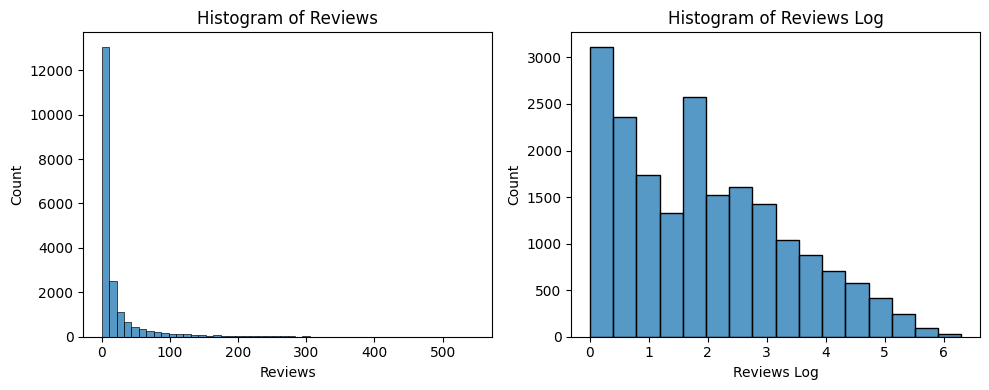

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the first and second histogram
sns.histplot(apartments['Reviews'], bins=50, ax=axes[0])
axes[0].set_title('Histogram of Reviews')
sns.histplot(apartments['Reviews Log'], bins=16, ax=axes[1])
axes[1].set_title('Histogram of Reviews Log')

plt.tight_layout()
plt.show()

**Distance from the center of the City**

In [94]:
# Calculate mean latitude and longitude
mean_latitude = apartments['Latitude'].mean()
mean_longitude = apartments['Longitude'].mean()

# Calculate distance from center for each record
apartments['Distance_from_center'] = apartments.apply(
    lambda row: great_circle(
        (row['Latitude'], row['Longitude']),
        (mean_latitude, mean_longitude)
    ).km,
    axis=1
)


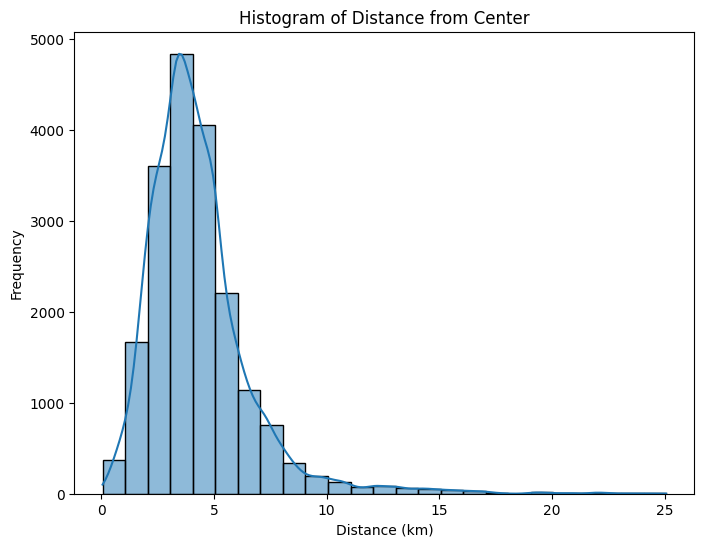

In [ ]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
sns.histplot(apartments['Distance_from_center'], bins=25, kde=True)
plt.title('Histogram of Distance from Center')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mean_dist = apartments['Distance_from_center'].mean()
std_dist = apartments['Distance_from_center'].std()
# Calculate +/- 3 sigma
dist_three_sigma_lower = mean_dist - 3 * std_dist
dist_three_sigma_upper = mean_dist + 3 * std_dist
print("Mean Distance:", mean_dist)
print("Standard Deviation Distance:", std_dist,'\n')
print("Сalculated boundaries")
print("3 Sigma Lower:", dist_three_sigma_lower)
print("3 Sigma Upper:", dist_three_sigma_upper,'\n')

Q98 = apartments['Distance_from_center'].quantile(0.98)
Q99 = apartments['Distance_from_center'].quantile(0.99)
Q995 = apartments['Distance_from_center'].quantile(0.995)

Q005 = apartments['Distance_from_center'].quantile(0.005)
Q01 = apartments['Distance_from_center'].quantile(0.01)
Q02 = apartments['Distance_from_center'].quantile(0.02)

print("Q005", Q005)
print("Q01", Q01)
print("Q02", Q02, '\n')

print("Q98", Q98)
print("Q99", Q99)
print("Q995", Q995)

Mean Distance: 4.30877205151679
Standard Deviation Distance: 2.339686931135316 

Сalculated boundaries
3 Sigma Lower: -2.7102887418891575
3 Sigma Upper: 11.327832844922739 

Q005 0.5877377073762312
Q01 0.7615549264373442
Q02 1.0953249418120623 

Q98 11.023225447464759
Q99 13.585162448854827
Q995 15.538290569057688


In [96]:
# prompt: корреляция Price и 'Distance_from_center' и p-value

from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
corr, p_value = pearsonr(apartments['Price'], apartments['Distance_from_center'])

print("Pearson correlation coefficient:", corr)
print("P-value:", p_value)


Pearson correlation coefficient: -0.11050337604367969
P-value: 1.7930878172929924e-54


In [ ]:
#apartments = apartments[apartments['Distance_from_center'] <= 16]
#apartments.shape

# Average of neighbors calculation

In [ ]:
def weighted_location_rating(lat, lon, lat_bin, lon_bin, df, target_col, weight_col, primary_threshold_m=250,
                             primary_bin_range = 1,  secondary_threshold_m=500, secondary_bin_range = 2):

    epsilon = 0.03  # Маленькое значение для предотвращения деления на ноль
    #  determine_bins(lat, lon, lat_bin, lon_bin)
    lat_bin = np.digitize(lat, lat_bin) - 1
    lon_bin = np.digitize(lon, lon_bin) - 1

    def calculate_weighted_average(threshold_km, bin_range):
        weighted_sum = 0
        total_weight = 0

        # objects from the nearest bins
        nearby_bins = df[(df['Latitude_Bin'] >= lat_bin - bin_range) & (df['Latitude_Bin'] <= lat_bin + bin_range) &
                         (df['Longitude_Bin'] >= lon_bin - bin_range) & (df['Longitude_Bin'] <= lon_bin + bin_range)]

        for i in range(len(nearby_bins)):
            lat_i, lon_i = nearby_bins.iloc[i]['Latitude'], nearby_bins.iloc[i]['Longitude']
            dist_km = great_circle((lat, lon), (lat_i, lon_i)).kilometers
            if dist_km <= threshold_km:
                weight = 1 / (dist_km + epsilon) * nearby_bins.iloc[i][weight_col]
                weighted_sum += nearby_bins.iloc[i][target_col] * weight
                total_weight += weight

        return weighted_sum, total_weight

    # Первоначальный расчет для соседних бинов (±1) и порога 500 метров
    threshold_km = primary_threshold_m / 1000
    weighted_sum, total_weight = calculate_weighted_average(threshold_km, bin_range = primary_bin_range)

    # Если нет точек в соседних бинах, увеличиваем диапазон до ±2 и порог до 1000 метров
    if total_weight == 0:
        threshold_km = secondary_threshold_m / 1000
        weighted_sum, total_weight = calculate_weighted_average(threshold_km, secondary_bin_range)  # для 500 бин 1

    if total_weight == 0:
        return np.nan # Если нет соседей, возвращаем 8 1/2, а не np.nan
    weighted_avg = weighted_sum / total_weight
    return weighted_avg

df = apartments[['Latitude', 'Longitude', 'Latitude_Bin', 'Longitude_Bin','Location Rating Roughly','Reviews Log']]
df.dropna(inplace=True)
print(df.shape)
df = df.reset_index(drop=True)


# Пример использования функции
lat = 52.489182
lon = 13.416555
weighted_rating = weighted_location_rating(lat, lon, lat_bin, lon_bin, df, weight_col = 'Reviews Log',
            target_col = 'Location Rating Roughly', primary_threshold_m=150, primary_bin_range = 1,
            secondary_threshold_m=500, secondary_bin_range = 2)
print(f"Weighted Location Rating: {weighted_rating}")

(16139, 6)
Weighted Location Rating: 9.620934607762823


# dataFrame for linear regression

In [ ]:
df = apartments[['Listing ID','Is Superhost','Latitude', 'Longitude', 'Accomodates',
                 'Bathrooms', 'Bedrooms', 'Beds', 'Price', 'Guests Included',
                 'Min Nights', 'Reviews', 'Overall Rating',
                 'Instant Bookable','Host Since Years', 'Last Review Years',
                 'First Review Years', 'Reviews Log', 'Location Rating Roughly',
                 'Price Log', 'Latitude_Bin', 'Longitude_Bin']]

In [ ]:
df.shape

(19786, 22)

In [ ]:
df.dropna(inplace=True)
df.shape

(16159, 22)

предобработка - расчет рейтинга места

In [ ]:
df.drop('Listing ID', axis=1, inplace=True)

# Разделяем данные на признаки и целевую переменную
y = df['Overall Rating']
X = df.drop('Overall Rating', axis=1)

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#X_trainT = X_train.sample(1000)
X_train['Average Location Rating'] = X_train.apply(lambda row:
        weighted_location_rating(row['Latitude'], row['Longitude'], lat_bin, lon_bin, X_train), axis=1)

In [ ]:
X_test['Average Location Rating'] = X_test.apply(lambda row:
        weighted_location_rating(row['Latitude'], row['Longitude'], lat_bin, lon_bin, X_train), axis=1)

In [ ]:
X_train.drop(['Latitude', 'Longitude', 'Reviews', 'Latitude_Bin', 'Longitude_Bin','Location Rating Roughly'], axis=1, inplace=True)
X_test.drop(['Latitude', 'Longitude', 'Reviews', 'Latitude_Bin', 'Longitude_Bin','Location Rating Roughly'], axis=1, inplace=True)

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Lasso
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
# import numpy as np



# # Нормализуем фичи
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Восстанавливаем названия столбцов
# X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


# Создаем линейную модель с L1-регуляризацией (Lasso)
#lasso = Lasso(alpha=0.1)  # alpha - параметр регуляризации

# Обучаем модель на тренировочной выборке
#lasso.fit(X_train, y_train)
reg = LinearRegression().fit(X_train, y_train)

# Делаем предсказания на тестовой и тренировочной выборках
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

# Считаем MAE, MSE, RMSE и R² для тестовой выборки
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test R² Score: {test_r2}')

# Считаем MAE, MSE, RMSE и R² для тренировочной выборки
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Train Mean Absolute Error: {train_mae}')
print(f'Train Mean Squared Error: {train_mse}')
print(f'Train Root Mean Squared Error: {train_rmse}')
print(f'Train R² Score: {train_r2}')

# Выводим коэффициенты модели с названиями фичей
#coef_df = pd.DataFrame(reg.coef_, index=X.columns, columns=['Coefficient'])
#print('Model Coefficients:')
#print(coef_df)

Test Mean Absolute Error: 4.871530053112203
Test Mean Squared Error: 54.57433244618059
Test Root Mean Squared Error: 7.387444243185906
Test R² Score: 0.03850116836352235
Train Mean Absolute Error: 4.631337870516803
Train Mean Squared Error: 50.062602450181785
Train Root Mean Squared Error: 7.075493088837115
Train R² Score: 0.08259703278160824
